In [1]:
%matplotlib notebook

# generic packages
import sys
import re, numpy as np, pandas as pd
from pprint import pprint
from matplotlib.ticker import PercentFormatter

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 1)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


# graphing, vis stuff
import matplotlib.pyplot as plt
import seaborn as sns

# additional libraries
from collections import Counter



# 1 Region and Domain

# 2 Research Question

"Which city division in the City of Toronto spent the most money in 2021 (and how does that compare with the distribution of its approved operating budget for 2021)?"



# 3 Links

In [2]:
# competitive contracts - City of Toronto

CC_URL = "https://wx.toronto.ca/inter/pmmd/callawards.nsf/postedawards?OpenView"
CC_URL2 = "https://wx.toronto.ca/inter/pmmd/callawards.nsf/postedawards?OpenView&Start=3.8.1"

# non-competitive contracts - City of Toronto
NC_URL = "https://wx.toronto.ca/inter/pmmd/solesource.nsf/posted?OpenView&Start=1&ExpandView"
NC_URL2 = "https://wx.toronto.ca/inter/pmmd/solesource.nsf/posted?OpenView&Start=1000&ExpandView"
NC_URL3 = "https://wx.toronto.ca/inter/pmmd/solesource.nsf/posted?OpenView&Start=1999&ExpandView"



In [3]:
# WORK THROUGH ... https://realpython.com/beautiful-soup-web-scraper-python/#step-2-scrape-html-content-from-a-page

from bs4 import BeautifulSoup
import requests

urls = [CC_URL, CC_URL2, NC_URL, NC_URL2, NC_URL3]
pages = [requests.get(url) for url in urls]
soups = [BeautifulSoup(page.text, "html.parser") for page in pages]

In [4]:
tables_per_url = [soups[i].find_all('table') for i in range(len(soups))]




In [5]:
# next: try using get_tables function here: https://towardsdatascience.com/a-guide-to-scraping-html-tables-with-pandas-and-beautifulsoup-7fc24c331cf7

def get_table(table_html):
    
    rows = []
    for child in table_html.children:
        row = []
        for td in child:
            try:
                row.append(td.text.replace('\n', ''))
            except:
                continue
        if len(row) > 0:
            rows.append(row)

    df = pd.DataFrame(rows[1:], columns=rows[0])
    return df
    
ncc_dfs = [get_table(tables_per_url[i][8]) for i in range(2,5)]
ncc_all = pd.concat(ncc_dfs)

cc_dfs = [get_table(tables_per_url[i][7]) for i in range(0,2)]
cc_all = pd.concat(cc_dfs)


In [6]:
cc_money_rows = cc_all[cc_all["Contract Amount"].notnull()]
ncc_money_rows = ncc_all[ncc_all["Contract Amount $"].notnull()]

In [7]:
ncc_cleaned = ncc_money_rows[['Sole Source Reference','Client Division', 'Description','Vendor Name','Contract Amount $','Contract Date']]
ncc_cleaned = ncc_cleaned.rename(columns={"Sole Source Reference":"ref_id",
                                         "Client Division":"division",
                                         "Description":"description",
                                         "Vendor Name":"vendor",
                                         "Contract Amount $":"contract_value",
                                         "Contract Date":"date"})

cc_cleaned = cc_money_rows[['Call Number','Client Division/Contact', 'Description','Successful Bidder','Contract Amount','Date awarded']]
cc_cleaned = cc_cleaned.rename(columns={"Call Number":"ref_id",
                                         "Client Division/Contact":"division",
                                         "Description":"description",
                                         "Successful Bidder":"vendor",
                                         "Contract Amount":"contract_value",
                                         "Date awarded":"date"})

In [8]:
ncc_cleaned["type"] = "non-competitive"
cc_cleaned["type"] = "competitive"

all_contracts = pd.merge(ncc_cleaned, cc_cleaned, how="outer", on=["ref_id", 
                                                                  "division",
                                                                  "description",
                                                                  "vendor",
                                                                  "contract_value",
                                                                  "type",
                                                                  "date"])
# set index to brief id
all_contracts = all_contracts.set_index("ref_id")

# clean up NA values in contracts
to_NaN = [r'^\s*$', r'n\/a', r'N\/A', r'--', r'NA'] 

for i in to_NaN:
    all_contracts.contract_value = all_contracts.contract_value.replace(i, np.nan, regex=True)
    all_contracts.vendor = all_contracts.vendor.replace(i, np.nan, regex=True)

all_contracts.contract_value = all_contracts.contract_value.replace(r'Cancelled', np.nan, regex=False)
all_contracts = all_contracts[~all_contracts['contract_value'].isna()]
all_contracts['currency'] = "CAD"

# reformat to accommodate USD entry
all_contracts.contract_value = all_contracts.contract_value.replace(r'[\$,]', '', regex=True).str.strip()
usd_rows = all_contracts[all_contracts['contract_value'].str.contains('USD')]
all_contracts.at[2375,'currency'] = 'USD'
all_contracts['contract_value'] = all_contracts['contract_value'].str.replace(' USD','').str.strip()

# convert money column to float
all_contracts.contract_value = all_contracts.contract_value.astype('float')

# convert time column to year only
all_contracts['date'] = pd.DatetimeIndex(all_contracts['date']).year

# remove 2022 as it is incomplete
all_contracts = all_contracts[all_contracts["date"] != 2022]

all_contracts[all_contracts["type"] == "competitive"]
all_contracts.to_csv("all_contracts_02152022.csv")


all_contracts[all_contracts["division"] == "- Choose one -"]

,division,description,vendor,contract_value,date,type,currency
ref_id,,,,,,,
3031373392,- Choose one -,"Midland Avenue – Road Reconstruction, Road Resurfacing, Watermain Replacement and Water Services from Sheppard Avenue Ea",NaN,1.1e+07,2021.0,competitive,CAD
Doc2852112229,- Choose one -,Servicing of Solmetex Hg5 Amalgam Separators,OCTAGON MEDICAL SERVICES,3.3e+04,2021.0,competitive,CAD
Doc2962047211,- Choose one -,Dental Equipment Repairs,K-Dental Inc.,6.3e+05,2021.0,competitive,CAD
Doc3133954872,- Choose one -,Forensic software and hardware,NaN,4.3e+05,2021.0,competitive,CAD
Doc3143590185,- Choose one -,SecureTransport Software and Maintenance Support,DUOLOGIK SOLUTIONS,7.8e+04,2021.0,competitive,CAD
2305234907,- Choose one -,Arboricultural Services,ONTARIO LINE CLEARING & TREE EXPERT,1.6e+07,2021.0,competitive,CAD
Doc2906091374,- Choose one -,"HDPE Pipes, Fittings and Fusion Services",CAPITAL SEWER SERVICES INC,7.5e+04,2021.0,competitive,CAD
Doc2871224079,- Choose one -,"Supply and Delivery of all Skilled Labour, Materials and Parts to Perform Maintenance and Repairs to Hydraulic Systems",Action Hydraulics Ltd.,2.8e+05,2021.0,competitive,CAD
3092946006,- Choose one -,Processing Services of Yard Waste,WALKER ENVIRONMENTAL GROUP INC,3.2e+06,2021.0,competitive,CAD


In [9]:
# fill in rows with incomplete 'client_division', based on ref_ID documents available here: https://wx.toronto.ca/inter/pmmd/callawards.nsf/postedawards?OpenView

corrections = [['3031373392', "Purchasing & Materials Management"],
['Doc2852112229', "Public Health"],
['Doc2962047211', "Public Health"],
['Doc3133954872 ', "Purchasing & Materials Management"],
['Doc3143590185', "Purchasing & Materials Management"],
['2305234907', "Parks, Forestry & Recreation"],
['Doc2906091374', "Solid Waste Management Services"],
['Doc2871224079', "Purchasing & Materials Management"],
['3092946006', "Solid Waste Management Services"],
               
['2485564575(9118-20-5043)', "Parks, Forestry & Recreation"],
['24855648594(9118-20-5042)', "Parks, Forestry & Recreation"],
['2333265407 (9118-20-5037)', "Parks, Forestry & Recreation"],
['2457091244 (9120-20-5041)', "Parks, Forestry & Recreation"],
['2918995784', "Parks, Forestry & Recreation"]]

for i in corrections:
    idx = i[0]
    all_contracts.at[idx,"division"] = i[1]

# remove Engineering Construction Services subcategories to merge all ECS contracts under 1 division

all_contracts["division"] = all_contracts["division"].str.replace(' - Capital Works Delivery', '')
all_contracts["division"] = all_contracts["division"].str.replace(' - Engineering Services', '')
all_contracts["division"] = all_contracts["division"].str.replace(' - Engineering Review','')

  
# correct incorrect funding total for ref_id = 2305234907, correct value: 40412989
all_contracts.at['2305234907', 'contract_value'] = 40412989

# also delete duplicate 
try:
  all_contracts = all_contracts.drop('2457091244(9120-20-5041)') 
except:
  print("duplicate not found, moving on")

# check again to make sure there are no new contracts to clean up

all_contracts[all_contracts["division"] == "- Choose one -"]


,division,description,vendor,contract_value,date,type,currency
ref_id,,,,,,,


In [10]:
# filter 2021 contracts only
contracts_2021 = all_contracts[all_contracts["date"] == 2021] 



# group by client_division and summarize
by_division = pd.DataFrame(contracts_2021.groupby("division")["contract_value"].sum().sort_values(ascending=False))

# calculate the contract value total (100%)
total_spending = round(sum(by_division.contract_value),2)

# tally the division totals as percentages of total
by_division["percent_of_total"] = by_division.contract_value / total_spending


# convert to percentage
by_division["percent_of_total"] = by_division["percent_of_total"].apply(lambda x: "{:.3%}".format(x))



# pivot data to split contract value between competitive & non-competitive contracts  
graph_data = (contracts_2021.pivot_table('contract_value', 
                                         index='division', 
                                         columns='type', 
                                         aggfunc='sum', 
                                         margins=True, 
                                         margins_name='total')
              .drop(['total'])
              .sort_values(by="total", ascending=False)
              .reset_index())

<IPython.core.display.Javascript object>


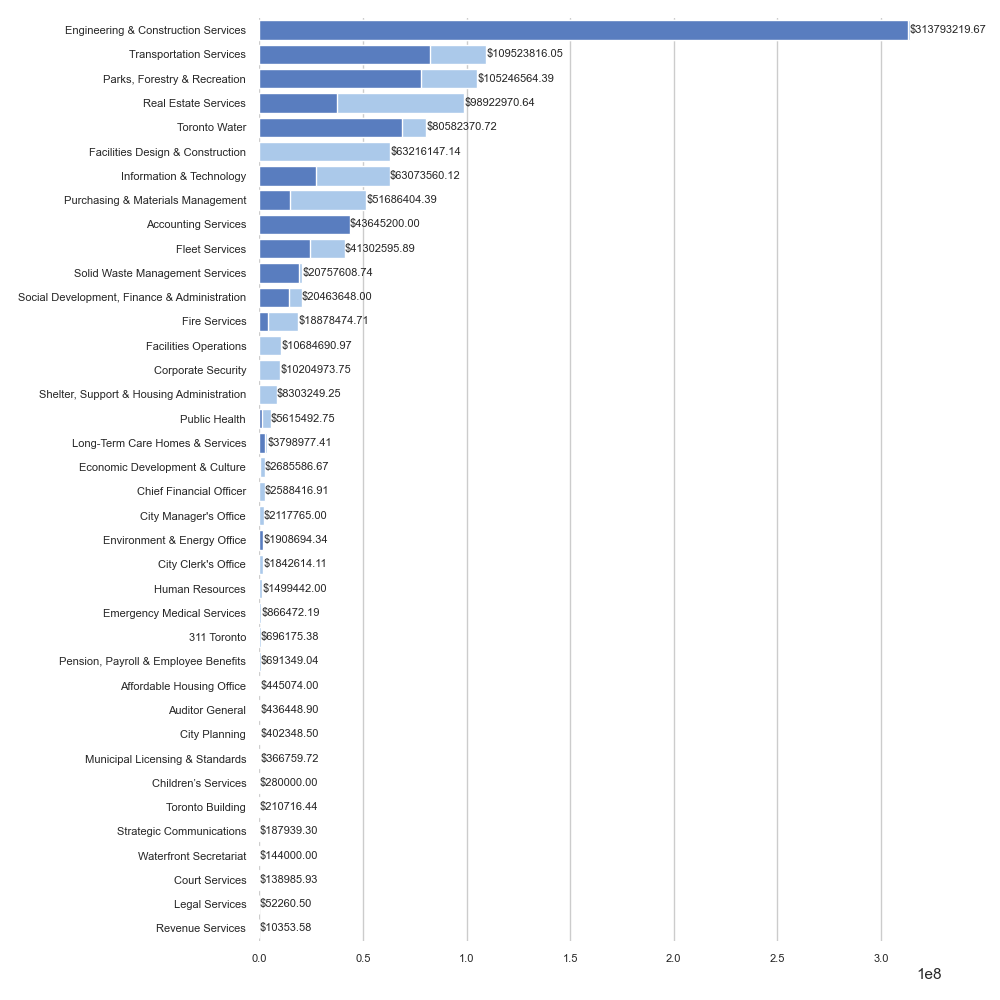

In [43]:
# Plot the total crashes with Seaborn
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))


sns.set_color_codes("pastel")
sns.barplot(x="total", y="division", data=graph_data,
            label="Total contract $", color="b").set(xlabel=None, ylabel=None)

for container in ax.containers:
    ax.bar_label(container, fmt='$%.2f', fontsize=8)


# Plot the competitive contracts
sns.set_color_codes("muted")
sns.barplot(x="competitive", y="division", data=graph_data,
            label="competitive contract $", color="b").set(xlabel=None, ylabel=None)

sns.despine(left=True, bottom=True)

# Adjust dimensions 
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()



# 4 Image

# 5 Discussion